In [1]:
# Loading all needed packages at the start
import elastix 
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import shutil

from FunctionsImageRegistration import *


## Fill in your own paths in the cell below ##

In [2]:
# to Elastix.exe
ELASTIX_PATH = r'C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe'
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)
# to Transformix.exe
TRANSFORMIX_PATH = r'C:\Users\20191679\Documents\Master\CS_image_analysis\Transformix.exe'
# to TrainingData
filepath_data = r'C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData'

### Default settings


In [3]:
# default settings for MI computation
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'


#### TO DO: Test out hypothesis: does the nr of bins in the MI computation function ever influence the order of the highest MI values?

## Per manually selected fixed image, find the five most similar moving image slices and perform B-spline transformation on them:


In [4]:
# Test set containing p119, p128, and p135 are left out!

patient_nrs_list = ['p102','p107', 'p108', 'p109', 'p115', 'p116', 'p117', 'p120', 'p125', 'p127', 'p129', 'p133']
#                    0      1       2       3       4       5       6       7       8       9       10      11       

# load all 12 patients' data (every 3D array) in one list, which has the same order as 'patient_nrs_list'
loaded_mr_list = []
for value in patient_nrs_list:
    loaded_mr, __ = loadPatientDataReadable(value, filepath=filepath_data)
    loaded_mr_list.append(loaded_mr)
    
# Generate 2D arrays for all patients
for patient_id in range(len(patient_nrs_list)):
    patient_id_fixed_image= patient_nrs_list[patient_id]
    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image
    fixed_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_id_fixed_image) # path to fixed image
    create2DImages(fixed_image_path, patient_id_fixed_image, filepath_data)
    create2DMasks(fixed_mask_path,patient_id_fixed_image, filepath_data)

print('Done creating 2D arrays')

Done creating 2D arrays


In [5]:
# Select (for now manually) which image is currently your fixed image -- # Enter image level of one fixed image
fixed_image_index = 5 # index in patient_nrs_list
patient_id_fixed_image = patient_nrs_list[fixed_image_index] # patient ID (for example 'p102') of fixed image
fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image

print('Patient selected as fixed image:', patient_id_fixed_image)

# select all but fixed image to use as moving image
train_mr_list_moving = []
for j in loaded_mr_list:
    train_mr_list_moving.append(j)
    
fixed_image_mr = train_mr_list_moving.pop(fixed_image_index) # 3D array of fixed image

# # # # Enter slice iterator of fixed image # # # # 

for image_slice_fixed in range(10,12): # when everything works: use 86. When everything is still being tested: keep it simple with 4. 
    
    print('Fixed image slice nr:', image_slice_fixed)

    list_of_list_MI, list_moving_slices_used = allMImovingImages(train_mr_list_moving, image_slice_fixed, fixed_image_mr)

    per_patient_per_slice_MI = intoOneList(list_of_list_MI)

    most_similar_list_index = sort_index(per_patient_per_slice_MI)[:5] # Get the five most similar images of all moving images
    #print(most_similar_list_index)

    patient_ids_similar = []
    slice_ids_similar = []
    for j in most_similar_list_index:
        patient_index_a, actual_slice_nr_a = getPatientAndSlice(j, list_moving_slices_used, train_mr_list_moving, patient_nrs_list)
        patient_ids_similar.append(patient_nrs_list[patient_index_a])
        slice_ids_similar.append(actual_slice_nr_a)
    
    # Perform B-spline registration for each most similar slice and store the results
    # # # # Enter iterator for most similar slices (paired with correct patient) # # # #
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5
        bspline_registration(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data, el_path=el)
        
        ## Visualization of results
        #visualize_bspline_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             #slice_ids_similar[work_down_list], filepath_data)
        #visualize_jacobian(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             #slice_ids_similar[work_down_list], filepath_data, tr_path=TRANSFORMIX_PATH)
        
        # Create a new parameter file
        newTransformParameterFile(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data)
    
        # Bspline registration of masks
        bspline_mask_registration(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data, TRANSFORMIX_PATH)
    
        ##Visualization of masks
        #visualize_bspline_mask_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             #slice_ids_similar[work_down_list], filepath_data)
        
        ## Overlay masks
        #overlay_mask(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             #slice_ids_similar[work_down_list], filepath_data)
    
    # STAPLE
    
    #Evaluation

Patient selected as fixed image: p116
Fixed image slice nr: 10
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\p116_slice10.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice12.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p116\bspline_results_slice_10\moving_slice_p102_12


KeyboardInterrupt: 

Fixed image slice nr: 10


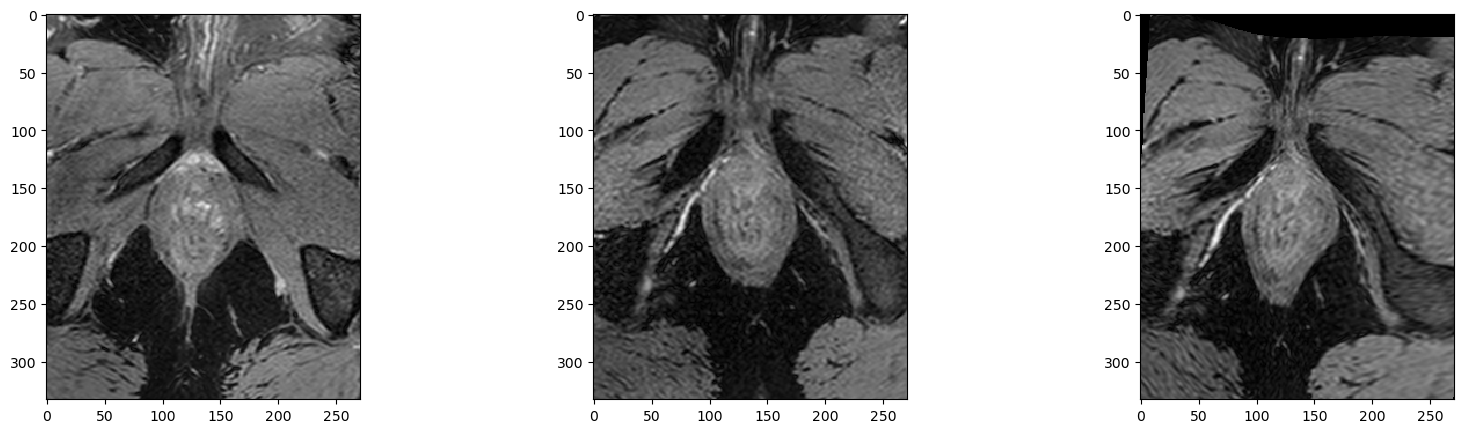

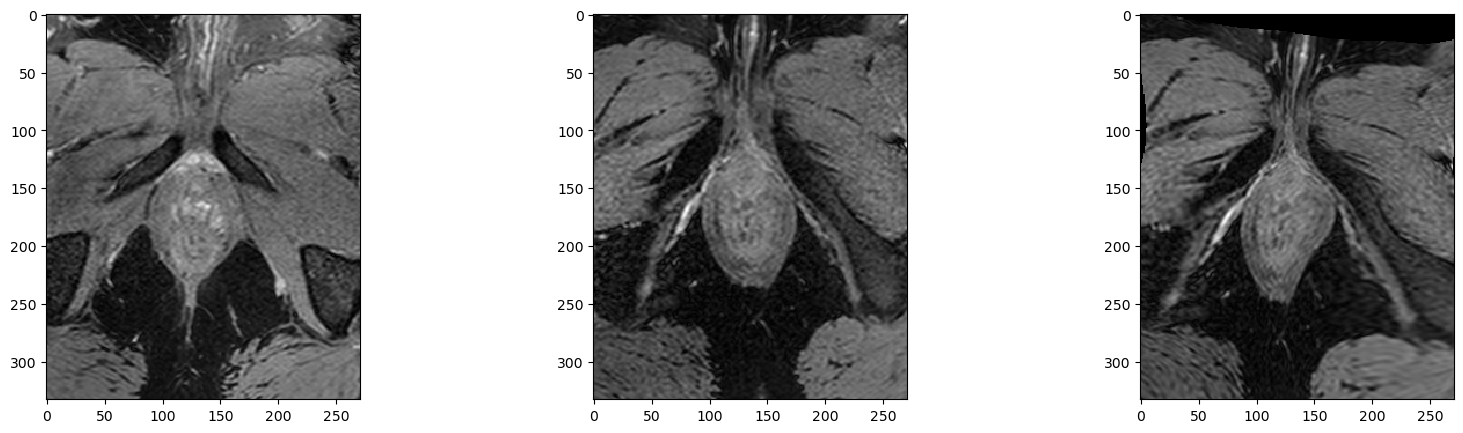

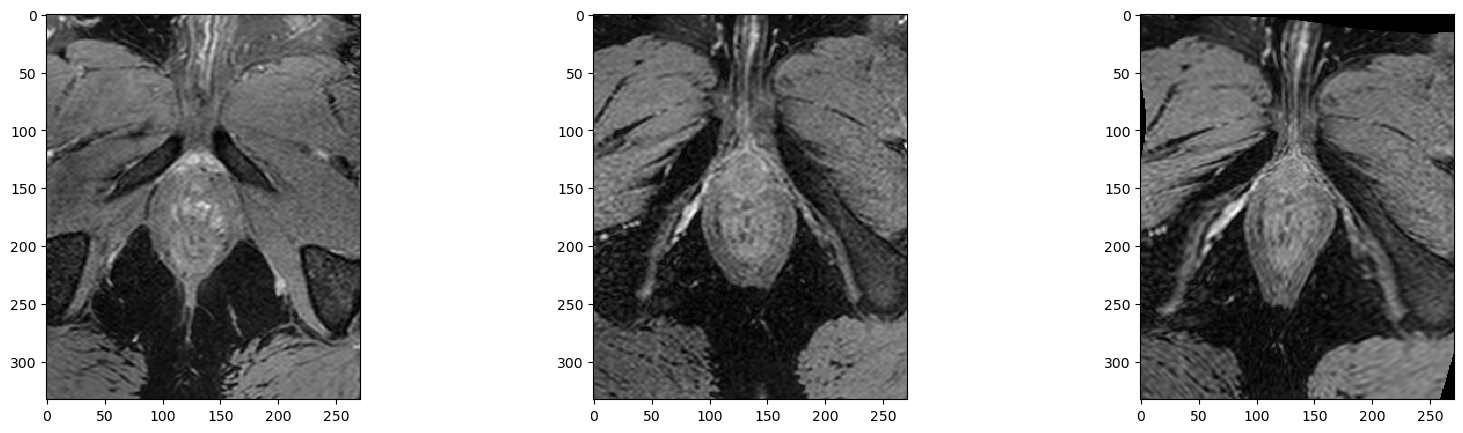

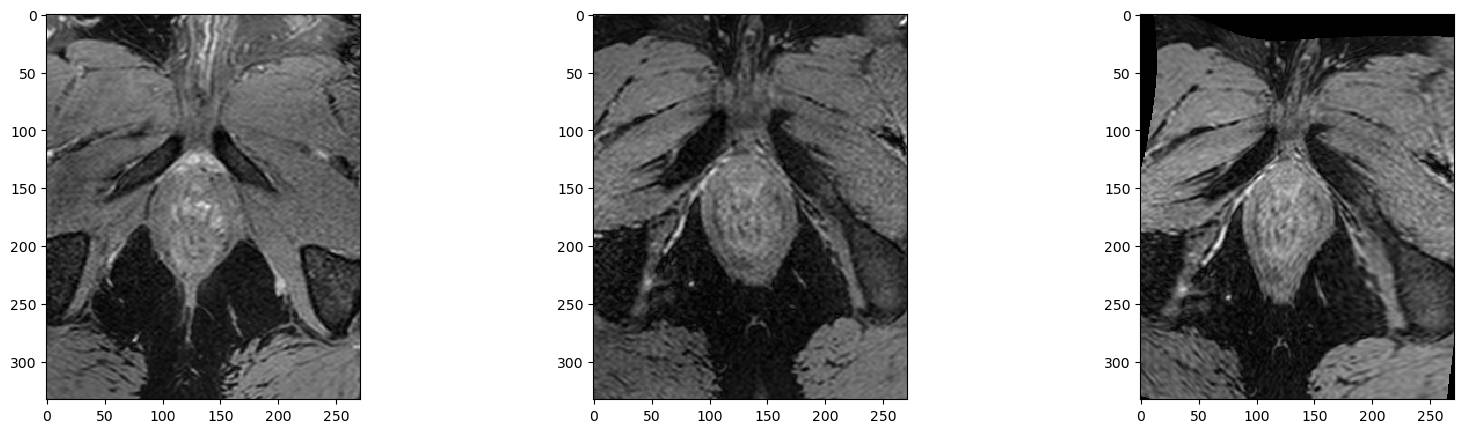

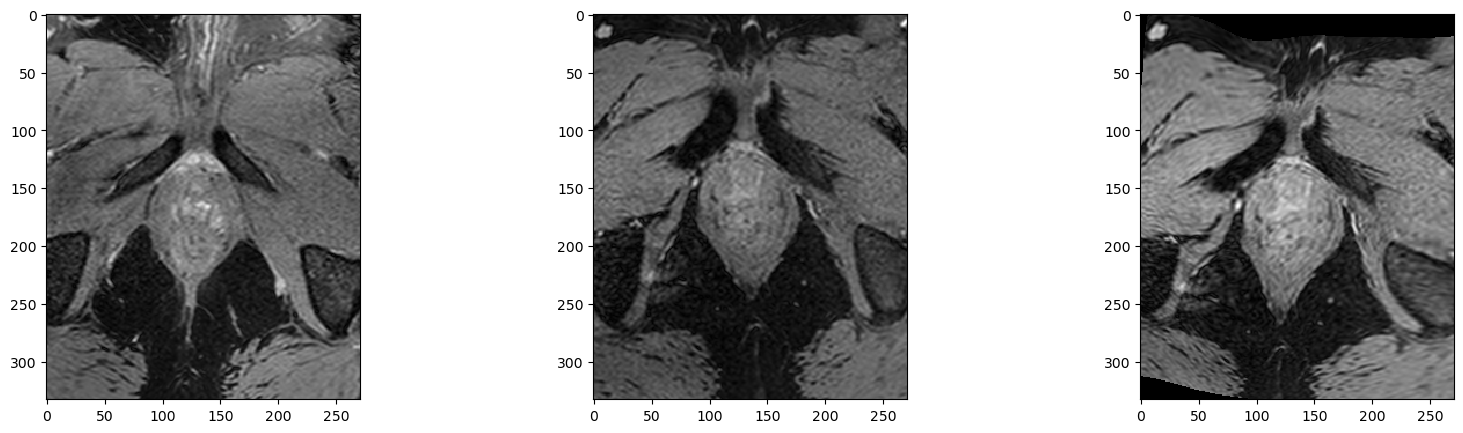

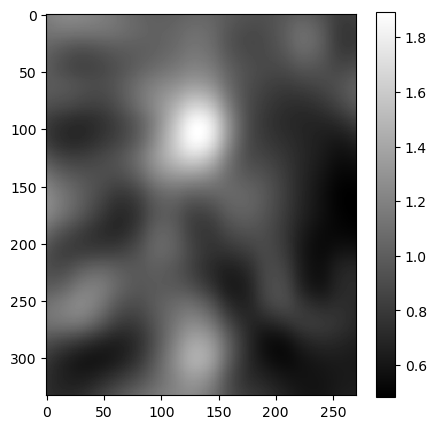

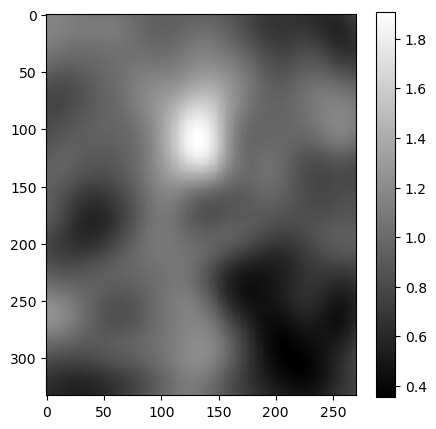

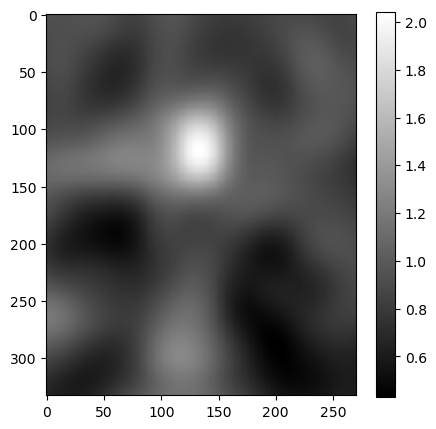

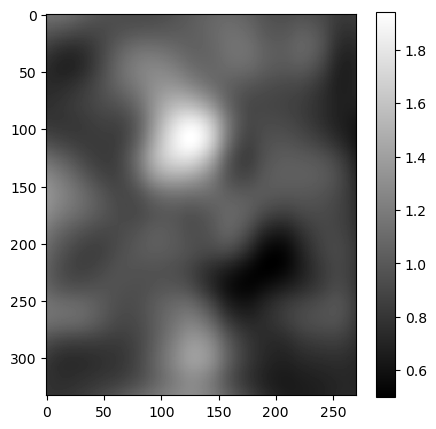

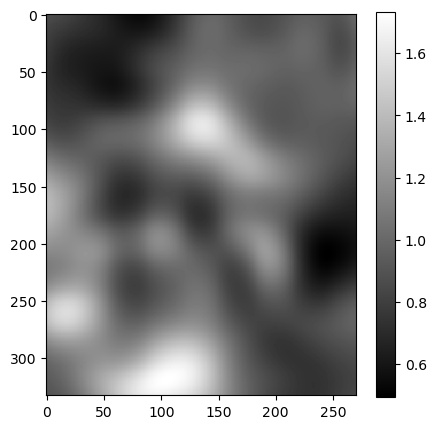

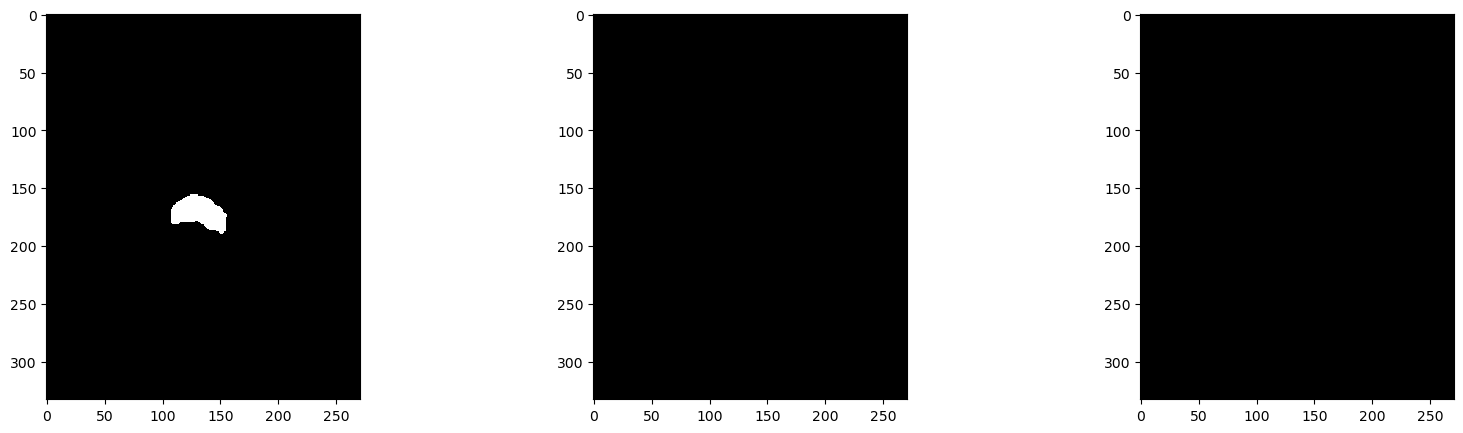

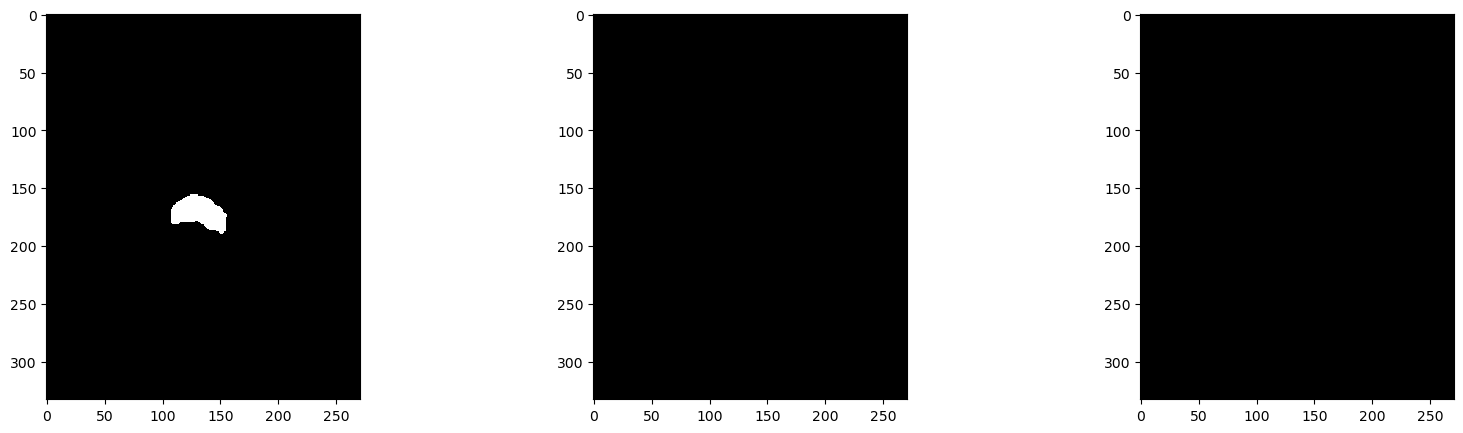

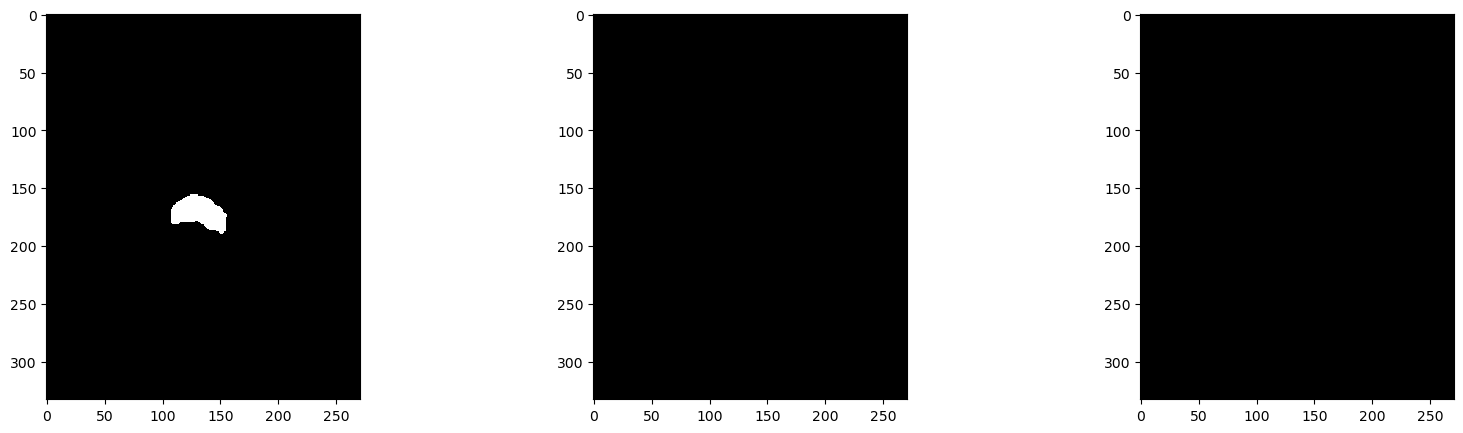

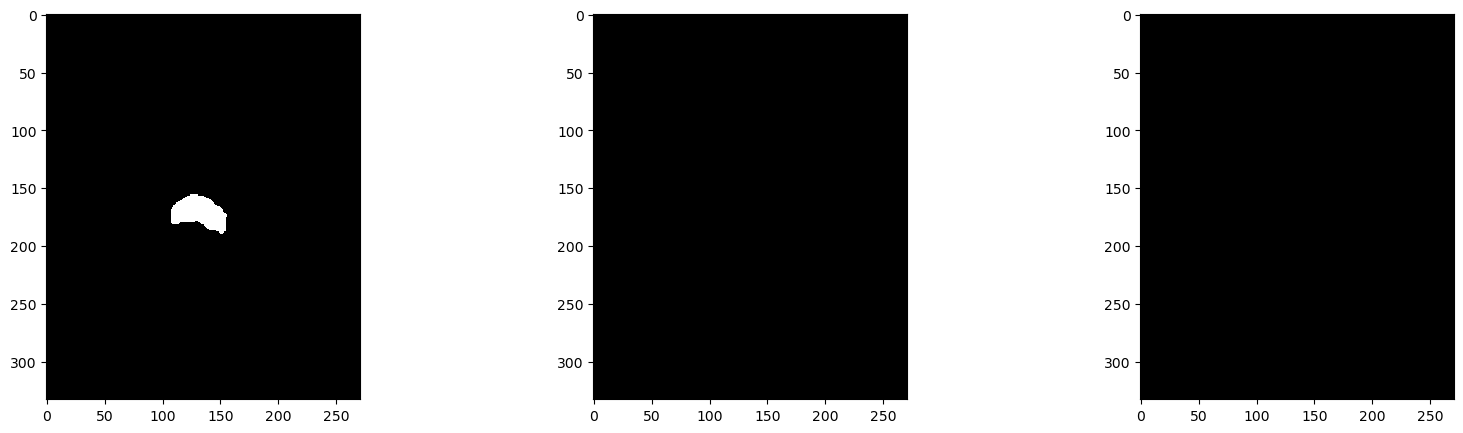

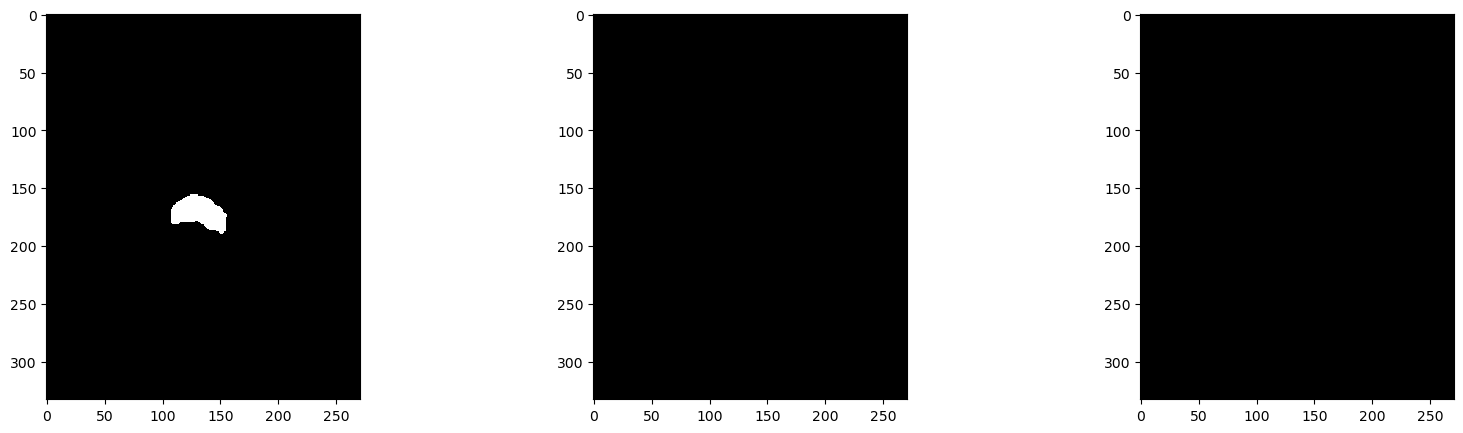

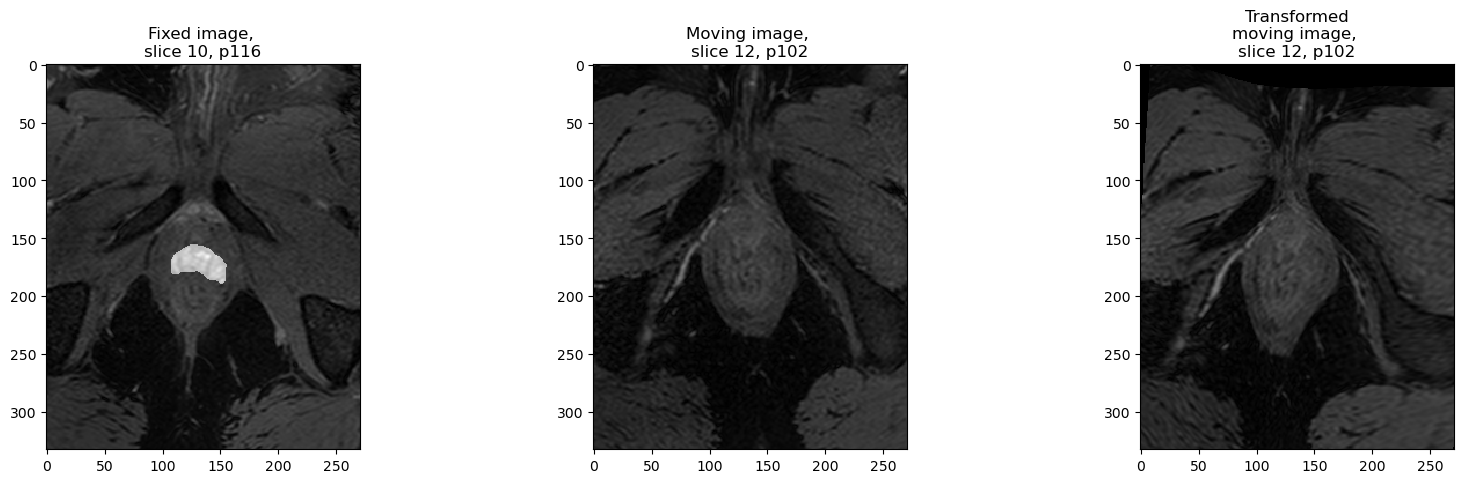

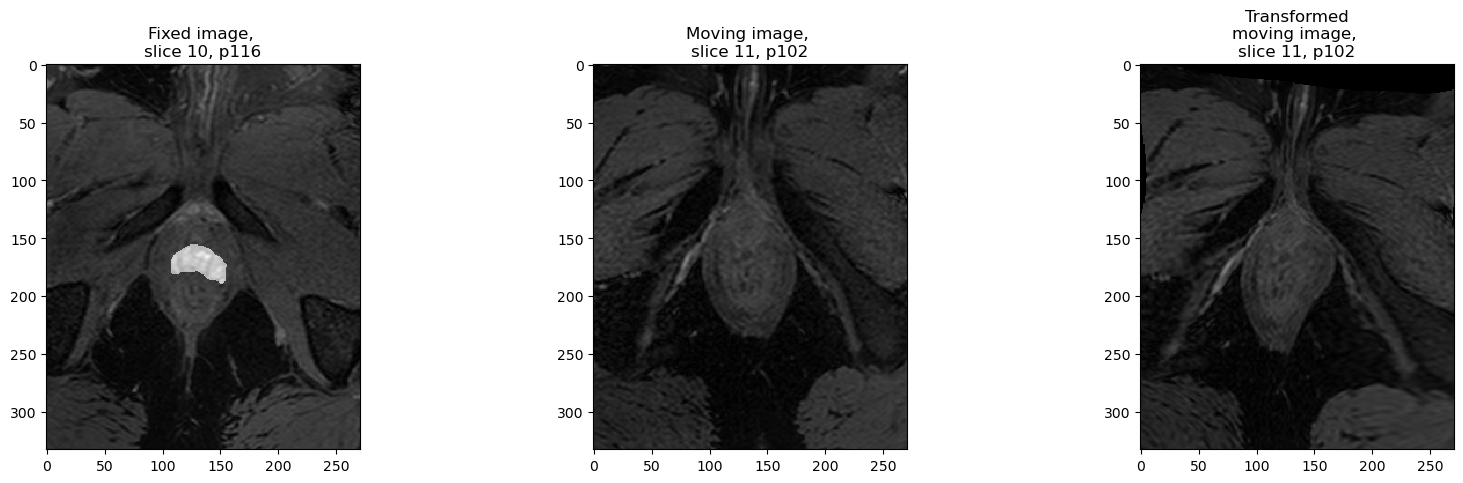

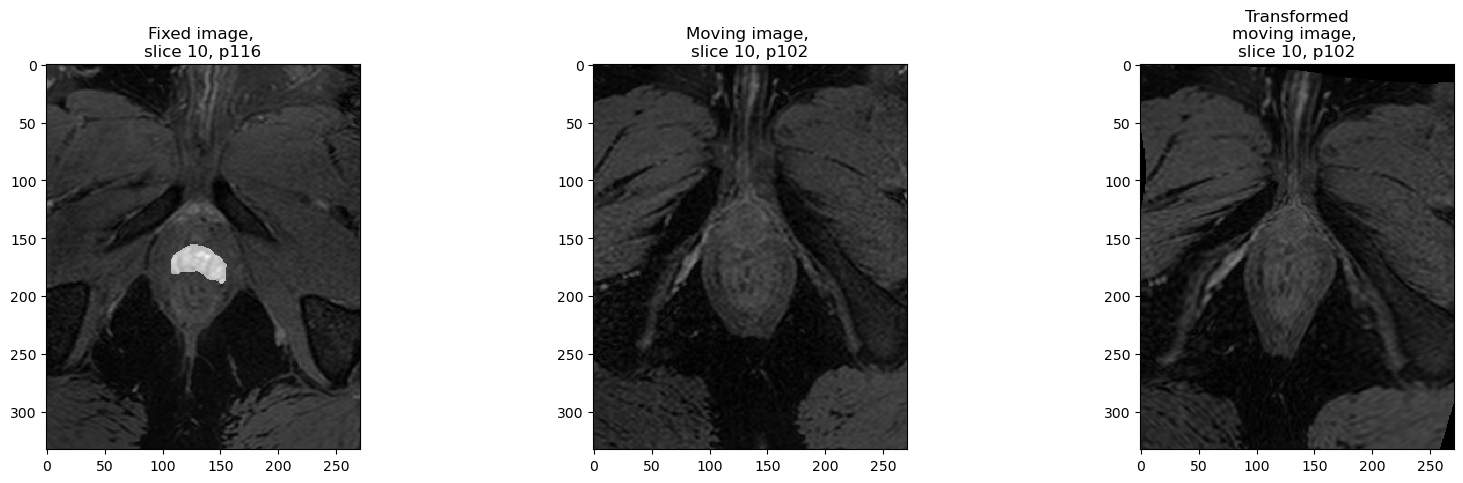

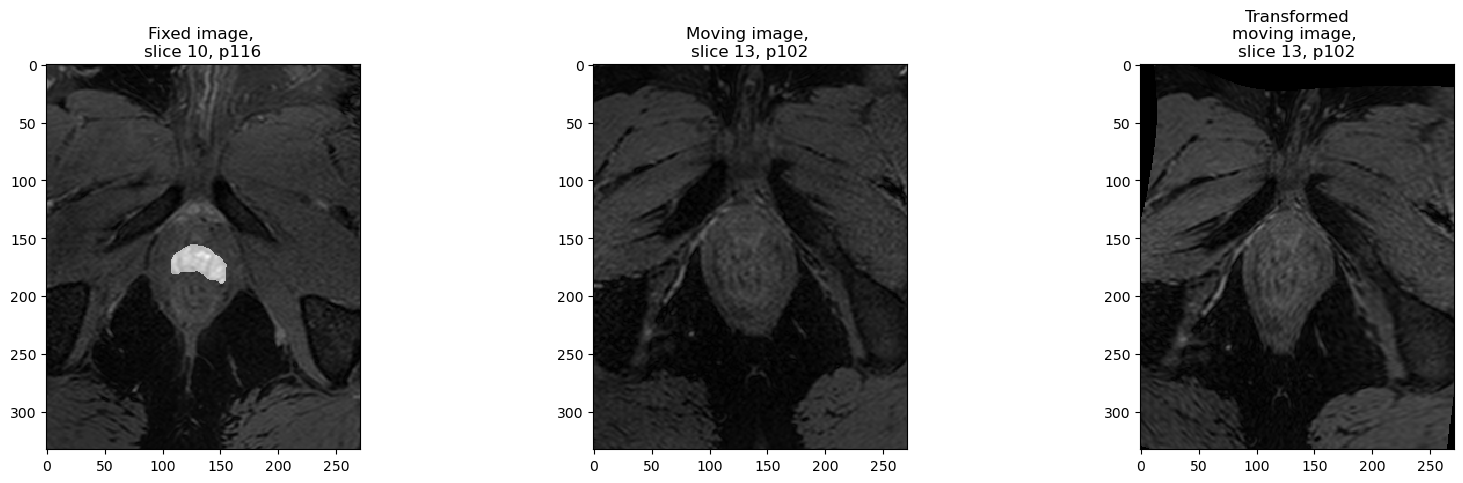

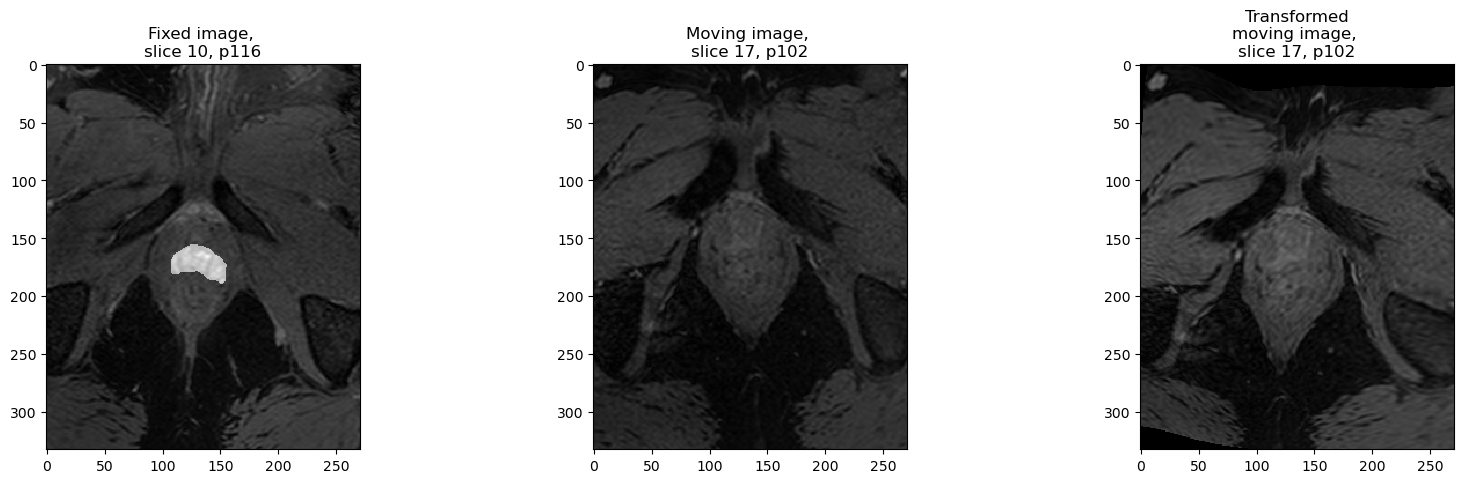

Fixed image slice nr: 11


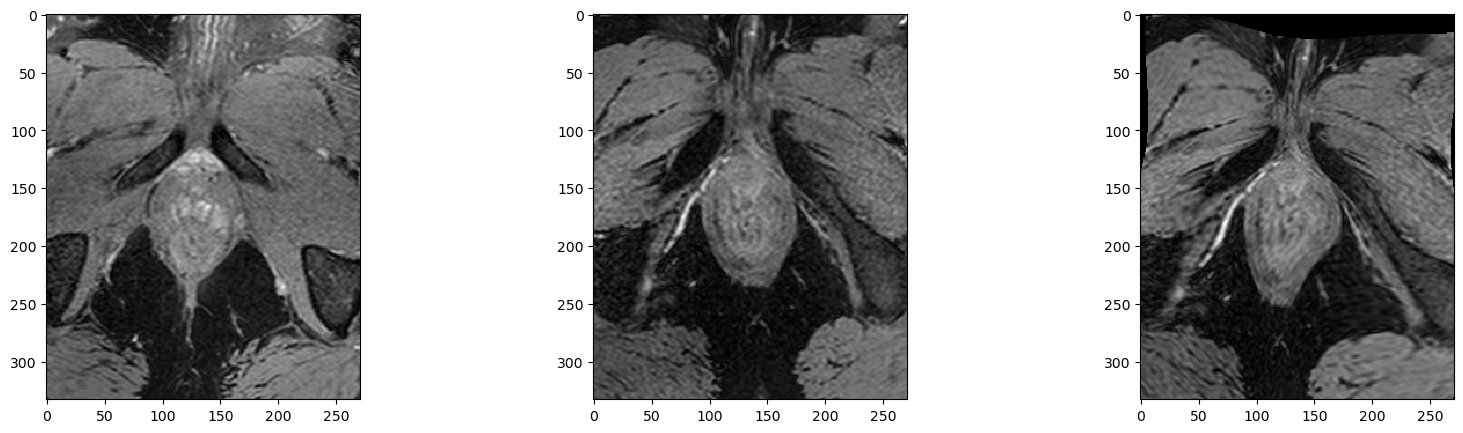

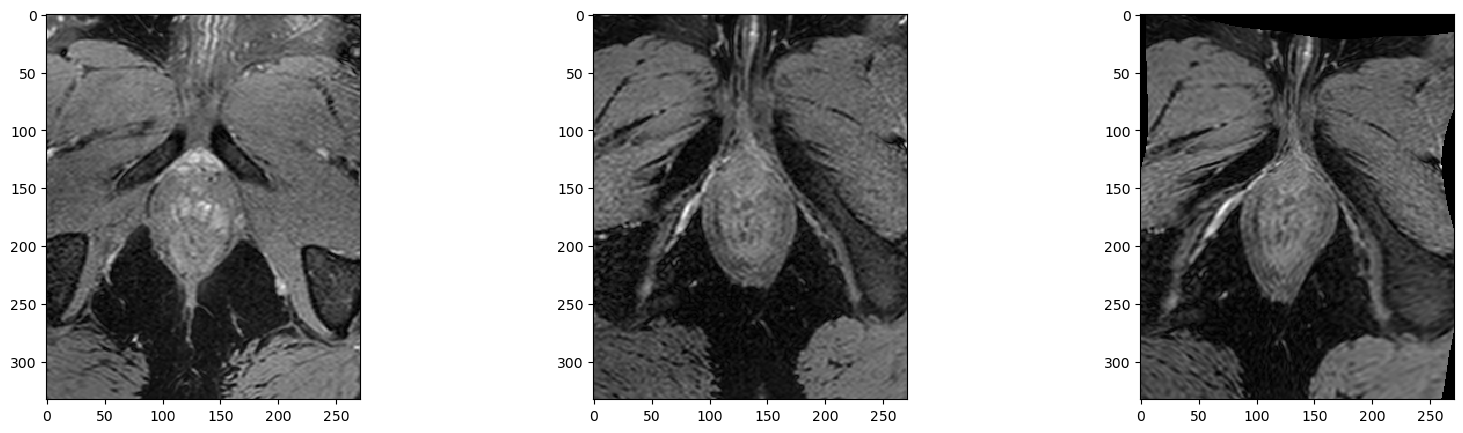

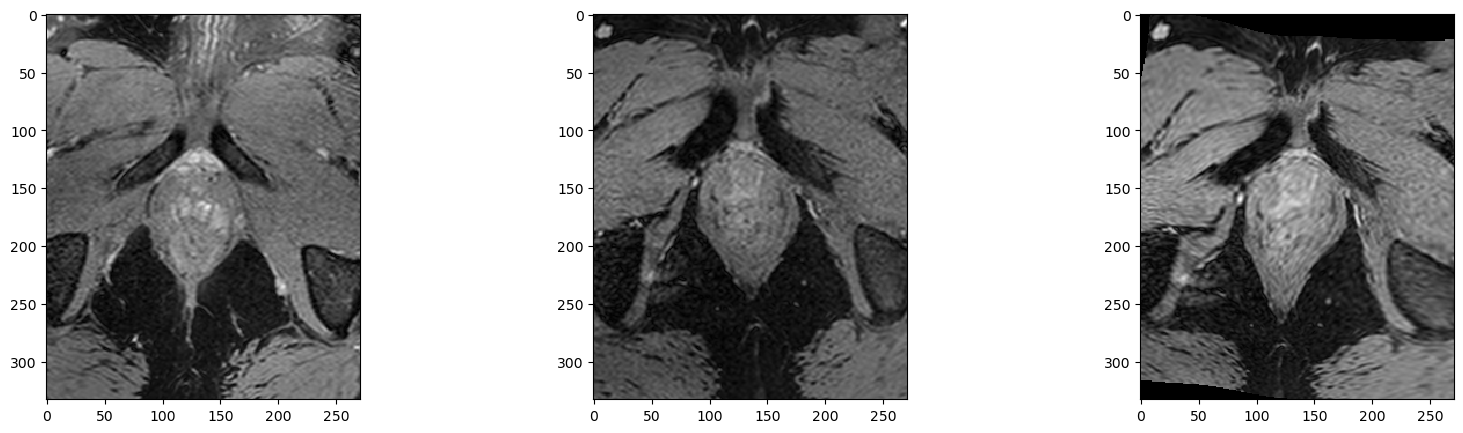

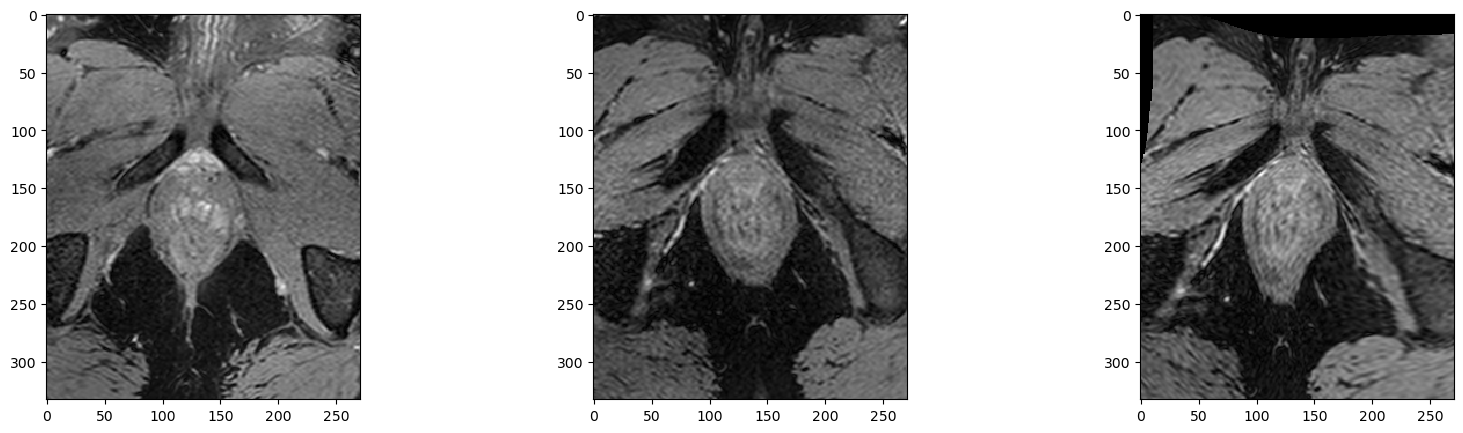

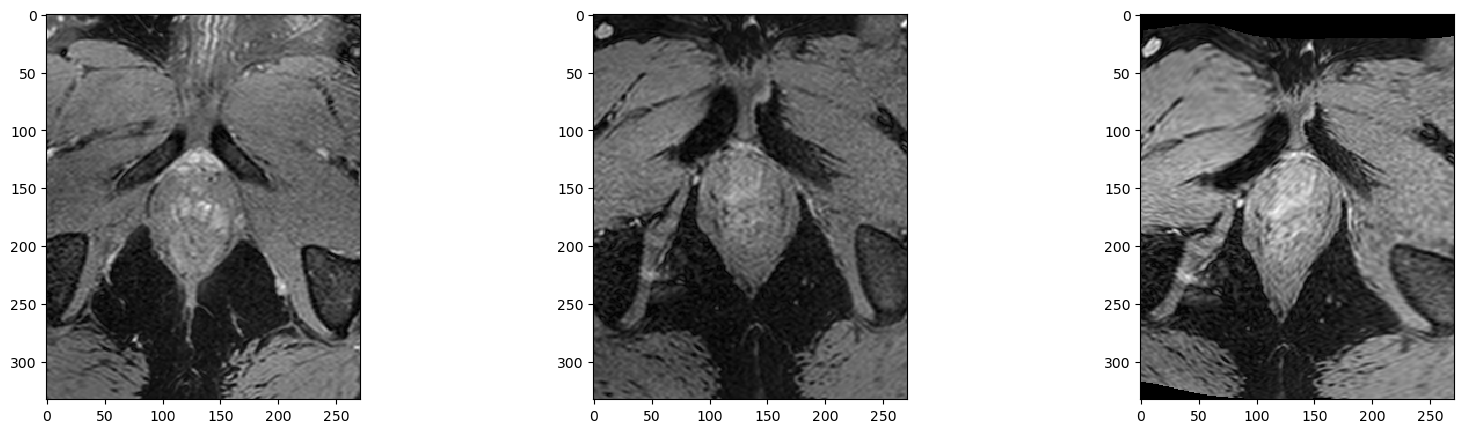

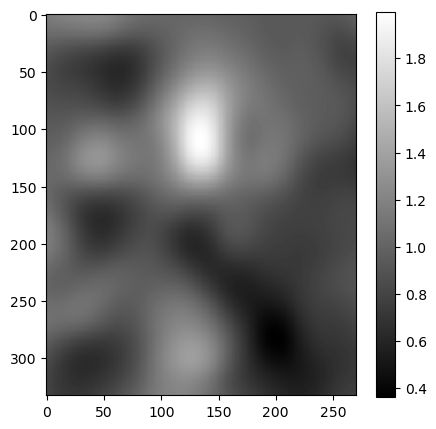

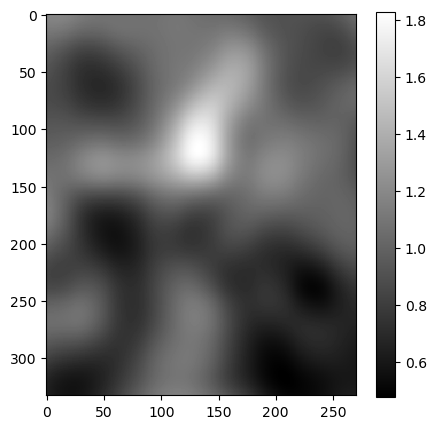

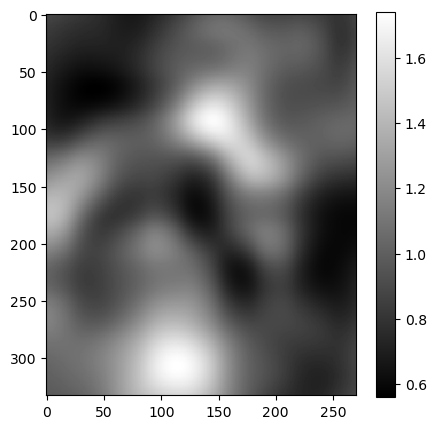

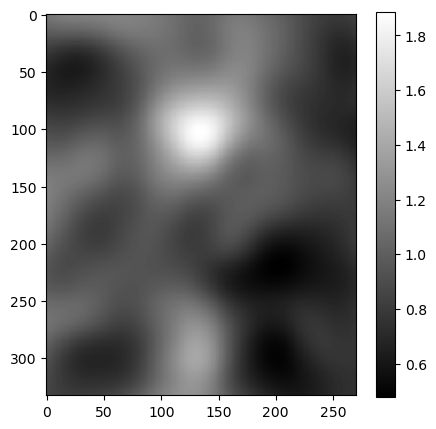

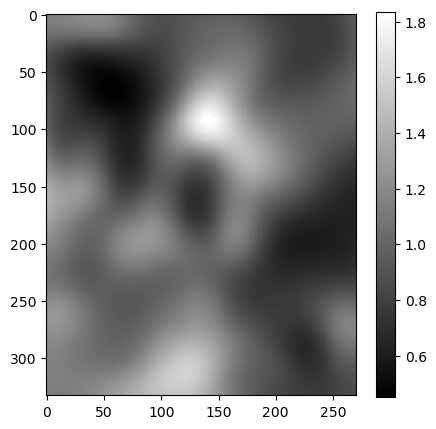

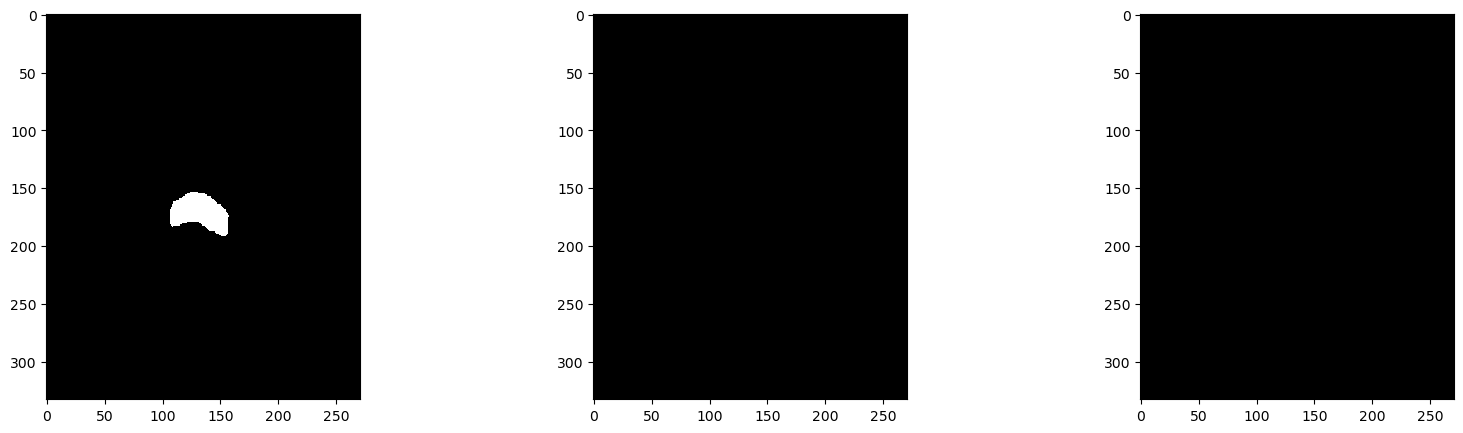

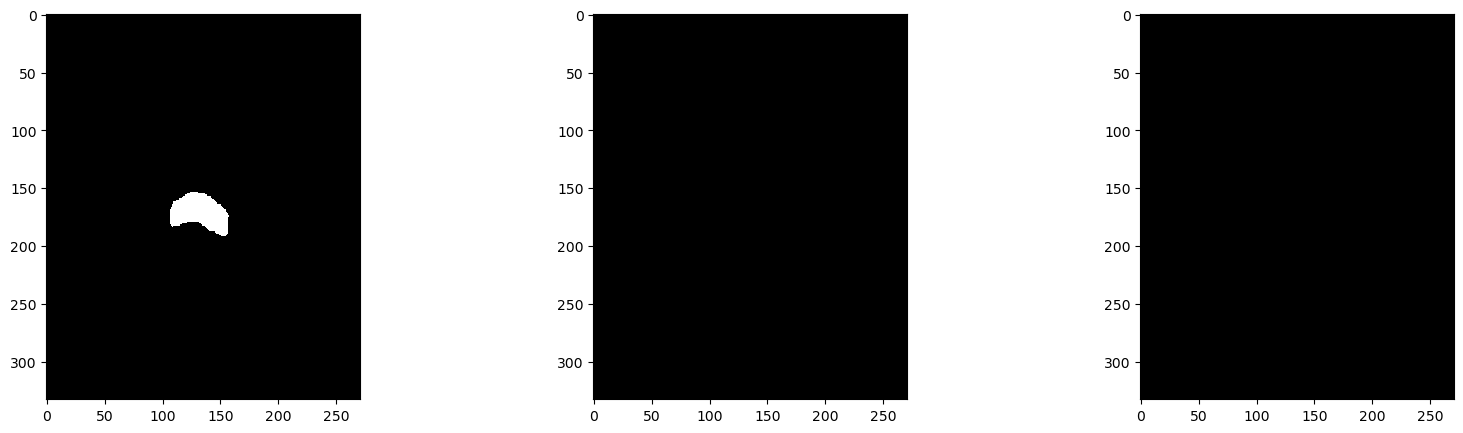

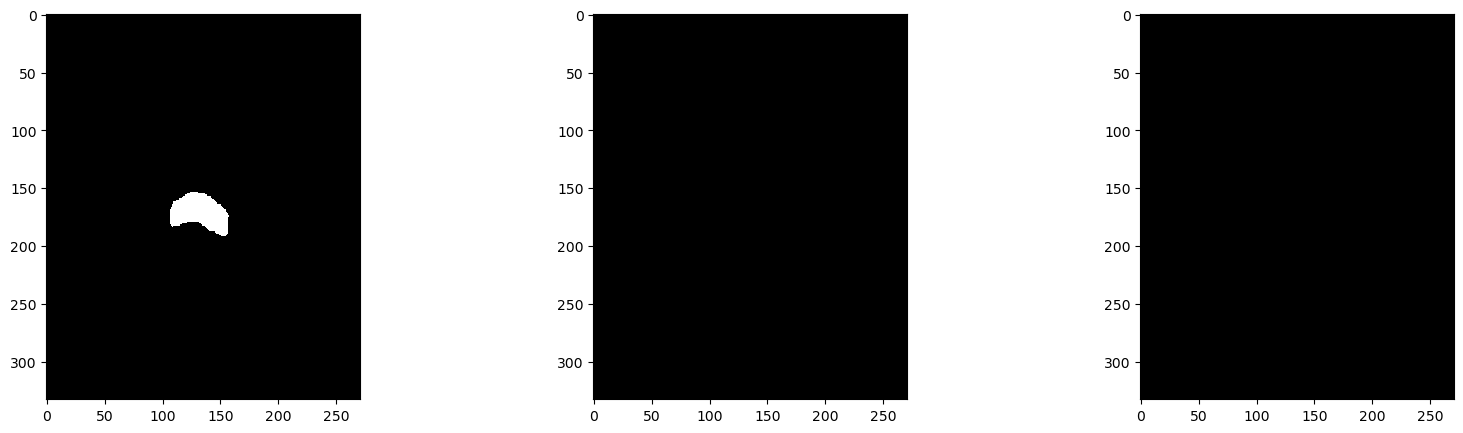

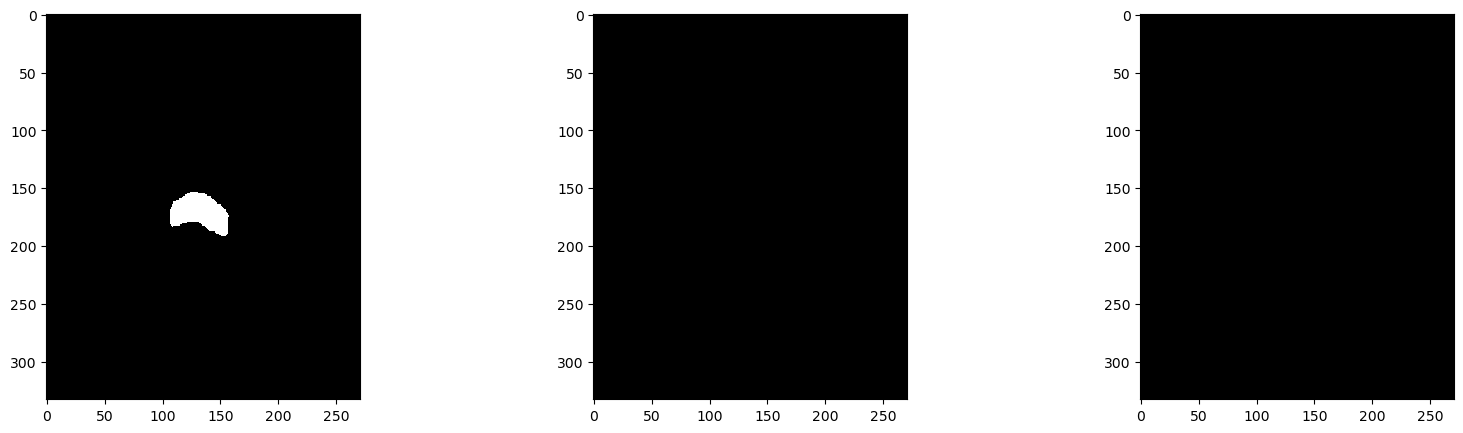

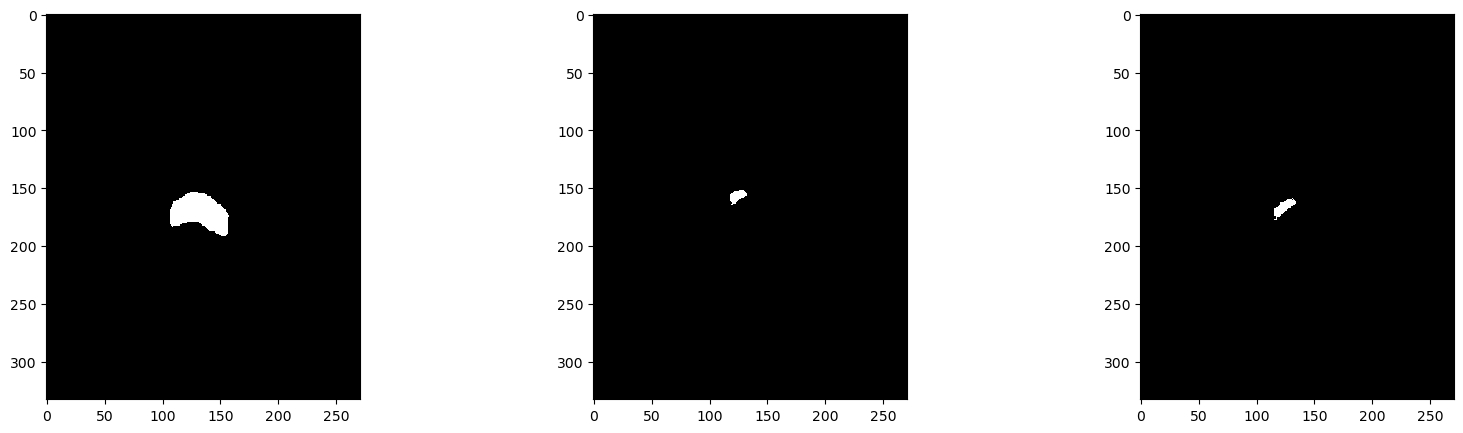

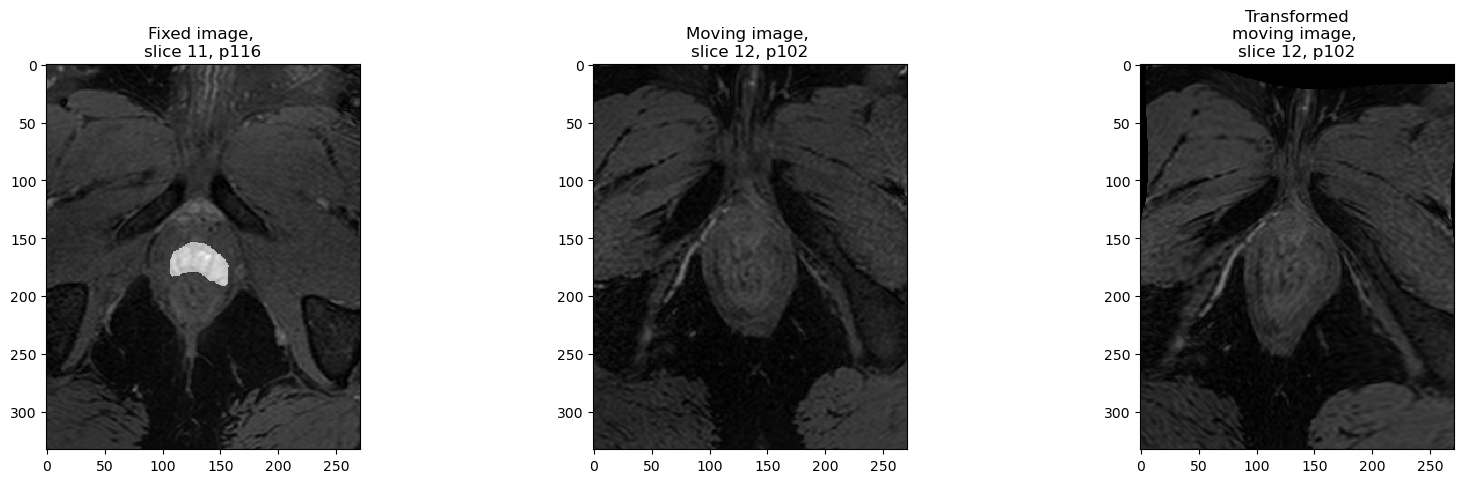

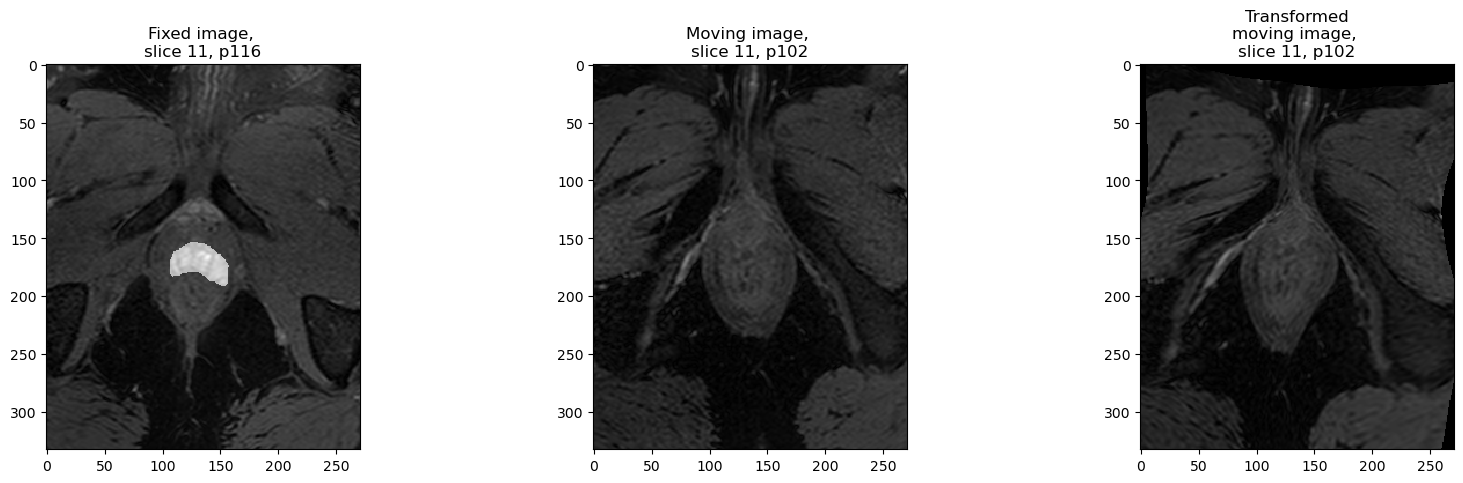

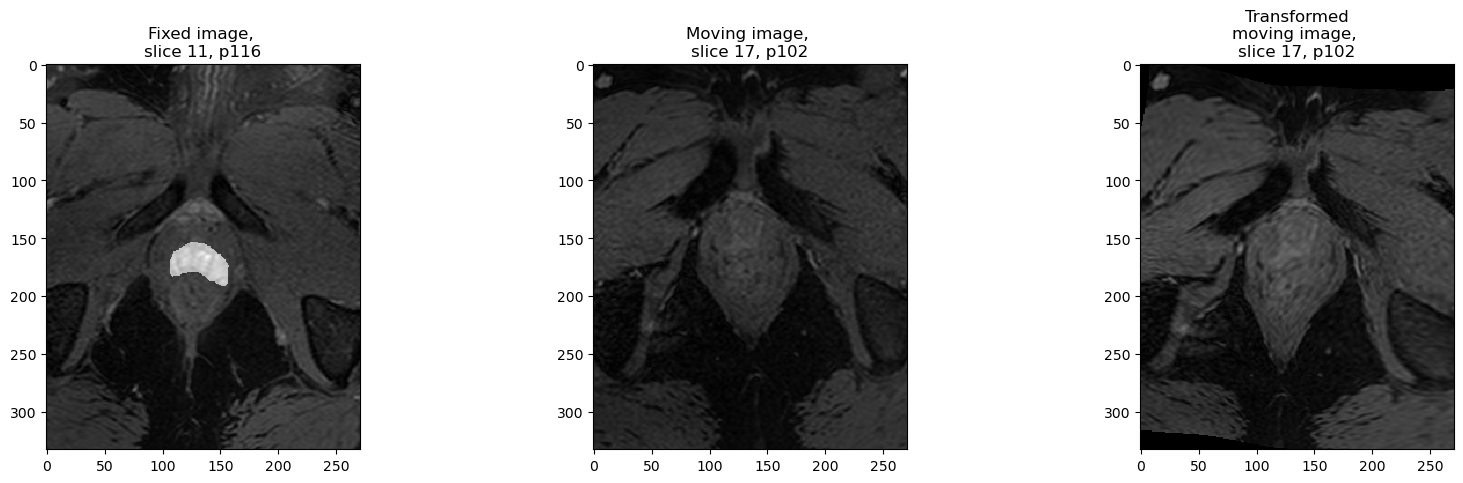

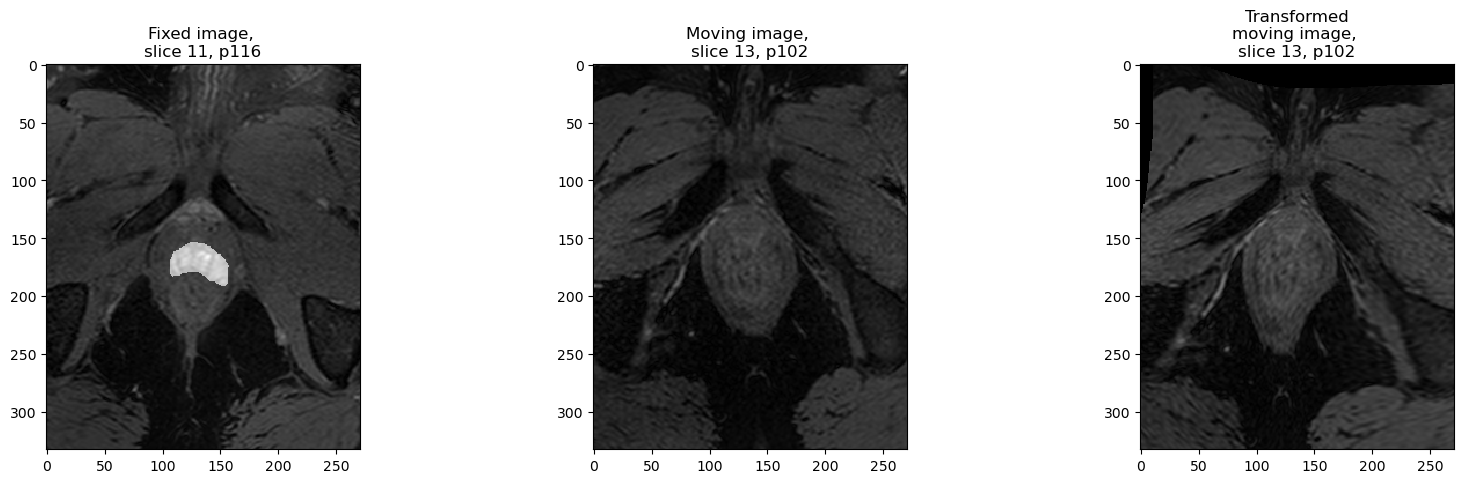

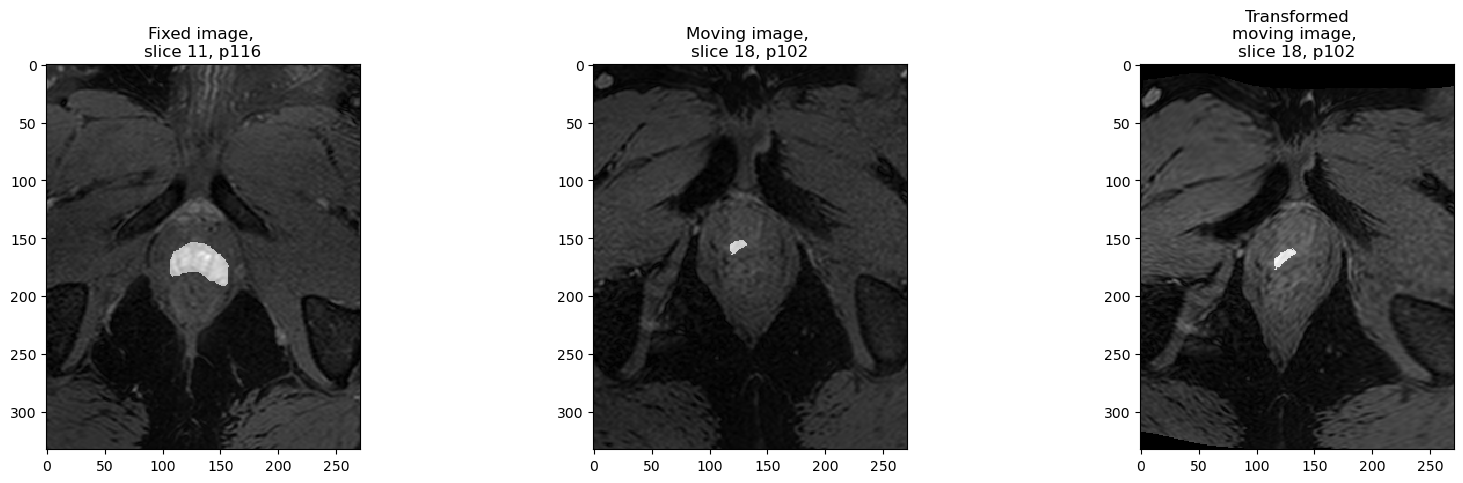

In [6]:
## Visualization of results separately
for image_slice_fixed in range(10,12): # when everything works: use 86. When everything is still being tested: keep it simple with 4. 
    
    #First get most similar slices (again)
    print('Fixed image slice nr:', image_slice_fixed)

    list_of_list_MI, list_moving_slices_used = allMImovingImages(train_mr_list_moving, image_slice_fixed, fixed_image_mr)

    per_patient_per_slice_MI = intoOneList(list_of_list_MI)

    most_similar_list_index = sort_index(per_patient_per_slice_MI)[:5] # Get the five most similar images of all moving images

    patient_ids_similar = []
    slice_ids_similar = []
    for j in most_similar_list_index:
        patient_index_a, actual_slice_nr_a = getPatientAndSlice(j, list_moving_slices_used, train_mr_list_moving, patient_nrs_list)
        patient_ids_similar.append(patient_nrs_list[patient_index_a])
        slice_ids_similar.append(actual_slice_nr_a)
        
    # Visualization of results
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5
        visualize_bspline_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data)
    
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5
        visualize_jacobian(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data, tr_path=TRANSFORMIX_PATH)
    
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5    
        visualize_bspline_mask_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data)
    
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5    
        overlay_mask(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data)
    